In [1]:
# Import Dataset
import pandas as pd

df = pd.read_csv('Bert-629-with-index.csv');
df.head(15)

,paragraph,Index
0,BERT <REF> is one of a series of pre-trained n...,0
1,Question <REF> Candidate Paragraph BERT : BERT...,1
2,DecAtt + Doc Reader <REF> 31.4 BERT 50.2 BERT...,2
3,"Specifically, we use SQuAD 1.1 <REF>.",3
4,"Specifically, we use SQuAD 1.1 <REF>.",4
5,"In recent years, deep pre-training approaches ...",5
6,"In recent years, transfer learning has achieve...",6
7,MKDM is implemented from BERT <REF>.,7
8,"In recent work, <REF> show that pretrained mod...",8
9,Inspired by the superiority of Transformer <RE...,9


In [2]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/virajaketkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/en_core_web_sm
-->
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
##Remove emails,newline,<REF> characters

# Convert to list
data = df.paragraph.values.tolist()
                

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data = [re.sub("<REF>", "", sent) for sent in data]
pprint(data[:1])


['BERT  is one of a series of pre-trained neural models that can be fine tuned '
 'to provide state-of-theart results in NLP including on the SQuAD and NQ '
 'tasks that align with our MRC based QA.']


Tokenize words and Clean-up text
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['bert', 'is', 'one', 'of', 'series', 'of', 'pre', 'trained', 'neural', 'models', 'that', 'can', 'be', 'fine', 'tuned', 'to', 'provide', 'state', 'of', 'theart', 'results', 'in', 'nlp', 'including', 'on', 'the', 'squad', 'and', 'nq', 'tasks', 'that', 'align', 'with', 'our', 'mrc', 'based', 'qa']]


 Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['bert', 'is', 'one', 'of', 'series', 'of', 'pre', 'trained', 'neural', 'models', 'that', 'can', 'be', 'fine_tuned', 'to', 'provide', 'state', 'of', 'theart', 'results', 'in', 'nlp', 'including', 'on', 'the', 'squad', 'and', 'nq', 'tasks', 'that', 'align', 'with', 'our', 'mrc', 'based', 'qa']


Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
#Let’s call the functions in order
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['bert', 'series', 'pre', 'train', 'neural', 'model', 'fine_tun', 'provide', 'state', 'theart', 'result', 'include', 'squad', 'task', 'align', 'mrc', 'base']]


Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [11]:
id2word[0]

'align'

Or, you can see a human-readable form of the corpus itself.

In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('align', 1),
  ('base', 1),
  ('bert', 1),
  ('fine_tun', 1),
  ('include', 1),
  ('model', 1),
  ('mrc', 1),
  ('neural', 1),
  ('pre', 1),
  ('provide', 1),
  ('result', 1),
  ('series', 1),
  ('squad', 1),
  ('state', 1),
  ('task', 1),
  ('theart', 1),
  ('train', 1)]]

Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

View the topics in LDA model
The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.144*"text" + 0.043*"task" + 0.040*"nlp" + 0.034*"state" + 0.032*"art" + '
  '0.030*"recently" + 0.029*"neural" + 0.029*"network" + 0.028*"many" + '
  '0.026*"show"'),
 (1,
  '0.147*"question" + 0.144*"answer" + 0.142*"long" + 0.140*"passage" + '
  '0.014*"span" + 0.011*"first" + 0.010*"knowledge" + 0.008*"encode" + '
  '0.007*"classifier" + 0.007*"linguistic"'),
 (2,
  '0.037*"set" + 0.031*"similar" + 0.028*"various" + 0.026*"describe" + '
  '0.024*"obtain" + 0.018*"test" + 0.018*"research" + 0.017*"employ" + '
  '0.016*"extraction" + 0.016*"finetune"'),
 (3,
  '0.131*"model" + 0.069*"base" + 0.066*"bert" + 0.049*"language" + '
  '0.032*"word" + 0.032*"representation" + 0.031*"train" + 0.028*"use" + '
  '0.027*"transformer" + 0.025*"task"'),
 (4,
  '0.059*"learning" + 0.048*"well" + 0.044*"experiment" + 0.022*"inference" + '
  '0.021*"section" + 0.018*"lead" + 0.017*"question_answere" + 0.016*"adopt" + '
  '0.014*"comprehension" + 0.013*"textual_entailment"'),
 (5,
  '0.282*"

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

Compute Model Perplexity and Coherence Score----
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.388550 -0.014054       1        1  41.754543
0      0.179332 -0.044194       2        1  15.949244
8     -0.071542 -0.032665       3        1   7.411271
9     -0.086236 -0.060981       4        1   6.466135
1     -0.031548  0.394088       5        1   6.000796
6     -0.073640 -0.058066       6        1   5.454998
5     -0.082160 -0.041692       7        1   4.904885
4     -0.060757 -0.052603       8        1   4.441527
2     -0.088433 -0.048250       9        1   4.152053
7     -0.073566 -0.041582      10        1   3.464555, topic_info=     Category        Freq            Term       Total  loglift  logprob
5     Default  775.000000           model  775.000000  30.0000  30.0000
463   Default  195.000000          single  195.000000  29.0000  29.0000
65    Default  323.000000            text  323.000000  28.0000  28.0000
412   Default  198.000000         develop  198.000000  27.0000  27.0000
189   Default  199.000000            line  199.000000  26.0000  26.0000
27    Default  125.000000        question  125.000000  25.0000  25.0000
105   Default  122.000000          answer  122.000000  24.0000  24.0000
261   Default  120.000000            long  120.000000  23.0000  23.0000
130   Default  119.000000         passage  119.000000  22.0000  22.0000
1     Default  406.000000            base  406.000000  21.0000  21.0000
2     Default  389.000000            bert  389.000000  20.0000  20.0000
101   Default  286.000000        language  286.000000  19.0000  19.0000
23    Default   69.000000           layer   69.000000  18.0000  18.0000
14    Default  246.000000            task  246.000000  17.0000  17.0000
17    Default   63.000000       attention   63.000000  16.0000  16.0000
40    Default   91.000000             nlp   91.000000  15.0000  15.0000
164   Default  190.000000            word  190.000000  14.0000  14.0000
77    Default  186.000000  representation  186.000000  13.0000  13.0000
16    Default  184.000000           train  184.000000  12.0000  12.0000
13    Default   77.000000           state   77.000000  11.0000  11.0000
414   Default   45.000000          method   45.000000  10.0000  10.0000
129   Default   73.000000             art   73.000000   9.0000   9.0000
163   Default  163.000000             use  163.000000   8.0000   8.0000
96    Default   68.000000        recently   68.000000   7.0000   7.0000
332   Default   37.000000        learning   37.000000   6.0000   6.0000
385   Default   34.000000          follow   34.000000   5.0000   5.0000
7     Default   66.000000          neural   66.000000   4.0000   4.0000
24    Default   65.000000         network   65.000000   3.0000   3.0000
28    Default  159.000000     transformer  159.000000   2.0000   2.0000
47    Default   63.000000            many   63.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
467   Topic10   12.354498        instance   13.144990   3.3006  -3.6751
534   Topic10   10.497044       wikipedia   11.287362   3.2900  -3.8380
732   Topic10    8.457143     translation    9.247561   3.2732  -4.0541
838   Topic10    8.414715        leverage    9.205040   3.2728  -4.0592
1331  Topic10    7.984542         quality    8.774832   3.2682  -4.1116
532   Topic10    6.143867     bookscorpus    6.934179   3.2416  -4.3737
533   Topic10    5.705480         english    6.495806   3.2329  -4.4477
439   Topic10    5.607012          metric    6.397403   3.2307  -4.4651
435   Topic10    4.972507           aware    5.763143   3.2150  -4.5852
1809  Topic10    4.663507             sit    5.453953   3.2060  -4.6494
861   Topic10    4.430718       translate    5.221025   3.1985  -4.7006
1801  Topic10    4.179660          google    4.970012   3.1894  -4.7589
1110  Topic10    4.135770           would    4.926203   3.1877  -4.7695
1107  Topic10    4.072913            cove    4.863362   3.1852  -4.78

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

 Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [17]:
!cd mallet-2.0.8.3

In [18]:
!pwd

/Users/virajaketkar/virajagit/paper-citation-summary


In [19]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/virajaketkar/virajagit/paper-citation-summary/mallet-2.0.8.3/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('bert', 0.10706787963610917),
   ('model', 0.05551667832983438),
   ('word', 0.05271751807790996),
   ('base', 0.031490552834149754),
   ('sentence', 0.028691392582225334),
   ('embedding', 0.026125495684627947),
   ('training', 0.019827385117797993),
   ('large', 0.018661068346162817),
   ('elmo', 0.017261488220200606),
   ('embed', 0.012362957779332866)]),
 (1,
  [('model', 0.07651006711409396),
   ('language', 0.07516778523489932),
   ('representation', 0.04899328859060403),
   ('transformer', 0.041834451901566),
   ('encoder', 0.02505592841163311),
   ('nlp', 0.024384787472035794),
   ('natural', 0.021252796420581657),
   ('layer', 0.018344519015659956),
   ('show', 0.018120805369127517),
   ('bidirectional', 0.01767337807606264)]),
 (2,
  [('task', 0.07271885132005558),
   ('train', 0.04886521537748958),
   ('pre', 0.03844372394627142),
   ('learn', 0.02176933765632237),
   ('state', 0.021306160259379342),
   ('art', 0.019916628068550254),
   ('text', 0.01968503937007874)

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

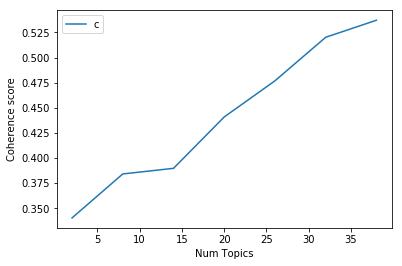

In [23]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3404
Num Topics = 8  has Coherence Value of 0.3841
Num Topics = 14  has Coherence Value of 0.3897
Num Topics = 20  has Coherence Value of 0.4408
Num Topics = 26  has Coherence Value of 0.4768
Num Topics = 32  has Coherence Value of 0.5201
Num Topics = 38  has Coherence Value of 0.5371


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [25]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.125*"show" + 0.111*"performance" + 0.063*"improve" + 0.039*"semantic" + '
  '0.037*"capture" + 0.036*"variety" + 0.031*"compare" + 0.031*"nlp" + '
  '0.028*"advance" + 0.023*"effective"'),
 (1,
  '0.314*"model" + 0.185*"language" + 0.097*"elmo" + 0.039*"gpt" + '
  '0.033*"masked" + 0.020*"report" + 0.020*"task" + 0.020*"pretrained" + '
  '0.014*"addition" + 0.012*"standard"'),
 (2,
  '0.110*"text" + 0.091*"dataset" + 0.035*"span" + 0.031*"generate" + '
  '0.031*"context" + 0.026*"approach" + 0.024*"score" + 0.023*"previous" + '
  '0.023*"pair" + 0.021*"original"'),
 (3,
  '0.161*"task" + 0.108*"recent" + 0.086*"pretraine" + 0.054*"fine_tun" + '
  '0.051*"work" + 0.050*"learning" + 0.050*"transfer" + 0.041*"language" + '
  '0.037*"downstream" + 0.029*"year"'),
 (4,
  '0.187*"sentence" + 0.115*"model" + 0.058*"training" + 0.038*"bert" + '
  '0.035*"provide" + 0.035*"give" + 0.035*"objective" + 0.032*"mask" + '
  '0.024*"target" + 0.024*"prediction"'),
 (5,
  '0.298*"word" + 0.1

Finding the dominant topic in each sentence
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [26]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.0854,"train, pre, bert, parameter, fine_tuning, mrc,...",BERT is one of a series of pre-trained neural...
1,1,8.0,0.2125,"layer, attention, transformer, multi, mechanis...",Question Candidate Paragraph BERT : BERT for ...
2,2,7.0,0.0814,"introduce, system, answer, squad, predict, des...",DecAtt + Doc Reader 31.4 BERT 50.2 BERT w/ SQ...
3,3,7.0,0.0673,"introduce, system, answer, squad, predict, des...","Specifically, we use SQuAD 1.1 ."
4,4,7.0,0.0673,"introduce, system, answer, squad, predict, des...","Specifically, we use SQuAD 1.1 ."
5,5,3.0,0.0847,"task, recent, pretraine, fine_tun, work, learn...","In recent years, deep pre-training approaches ..."
6,6,3.0,0.0970,"task, recent, pretraine, fine_tun, work, learn...","In recent years, transfer learning has achieve..."
7,7,6.0,0.0702,"bert, set, baseline, experiment, make, similar...",MKDM is implemented from BERT .
8,8,14.0,0.0960,"feature, deep, representation, language, apply...","In recent work, show that pretrained modules ..."
9,9,2.0,0.0956,"text, dataset, span, generate, context, approa...",Inspired by the superiority of Transformer on...


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [27]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,15.0,"train, pre, bert, parameter, fine_tuning, mrc,...",62.0,0.0619
1,8.0,"layer, attention, transformer, multi, mechanis...",39.0,0.0390
2,7.0,"introduce, system, answer, squad, predict, des...",28.0,0.0280
3,7.0,"introduce, system, answer, squad, predict, des...",47.0,0.0470
4,7.0,"introduce, system, answer, squad, predict, des...",48.0,0.0480
5,3.0,"task, recent, pretraine, fine_tun, work, learn...",92.0,0.0919
6,3.0,"task, recent, pretraine, fine_tun, work, learn...",51.0,0.0509
7,6.0,"bert, set, baseline, experiment, make, similar...",50.0,0.0500
8,14.0,"feature, deep, representation, language, apply...",57.0,0.0569
9,2.0,"text, dataset, span, generate, context, approa...",58.0,0.0579


We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [28]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.1766,"show, performance, improve, semantic, capture, variety, compare, nlp, advance, effective","Transformers have shown state of the art performance across a variety of NLP tasks, including, ..."
1,1.0,0.1335,"model, language, elmo, gpt, masked, report, task, pretrained, addition, standard","Model Architectures of BERT, GPT and ELMo Quoted from BERT As shown in , both ELMo and GPT mode..."
2,2.0,0.4450,"text, dataset, span, generate, context, approach, score, previous, pair, original",Our approach consists of following steps: (1) parse original protocol into a collection of proto...
3,3.0,0.1708,"task, recent, pretraine, fine_tun, work, learning, transfer, language, downstream, year","While the pretraining tasks have been designed with particular downstream tasks in mind , we foc..."
4,4.0,0.1914,"sentence, model, training, bert, provide, give, objective, mask, target, prediction","• It introduces structure-invariant testing (SIT), a novel, widely applicable methodology for va..."
5,5.0,0.2380,"word, embedding, embed, vector, contextual, context, vec, glove, contextualize, encode","Contextual Embeddings in General Traditional word-level vector representations, such as word2vec..."
6,6.0,0.1792,"bert, set, baseline, experiment, make, similar, datum, section, good, development","Additionally, as described in ), finetuning on BERT sometimes is observed to be unstable on smal..."
7,7.0,0.2686,"introduce, system, answer, squad, predict, describe, number, study, generation, current",The Story Cloze (also referred to as ROC Stories) involves predicting the correct story ending f...
8,8.0,0.2231,"layer, attention, transformer, multi, mechanism, head, lstm, hide, decoder, block","Transformer which computes a score similarly to the BiLSTMs scorer, except that each bi-LSTM la..."
9,9.0,0.1606,"representation, transformer, encoder, bidirectional, contextualized, universal, adopt, utilize, ...","In this section, we briefly review BERT (Bidirectional Encoder Representation from Transformers ..."


Frequency Distribution of Word Counts in Documents
When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

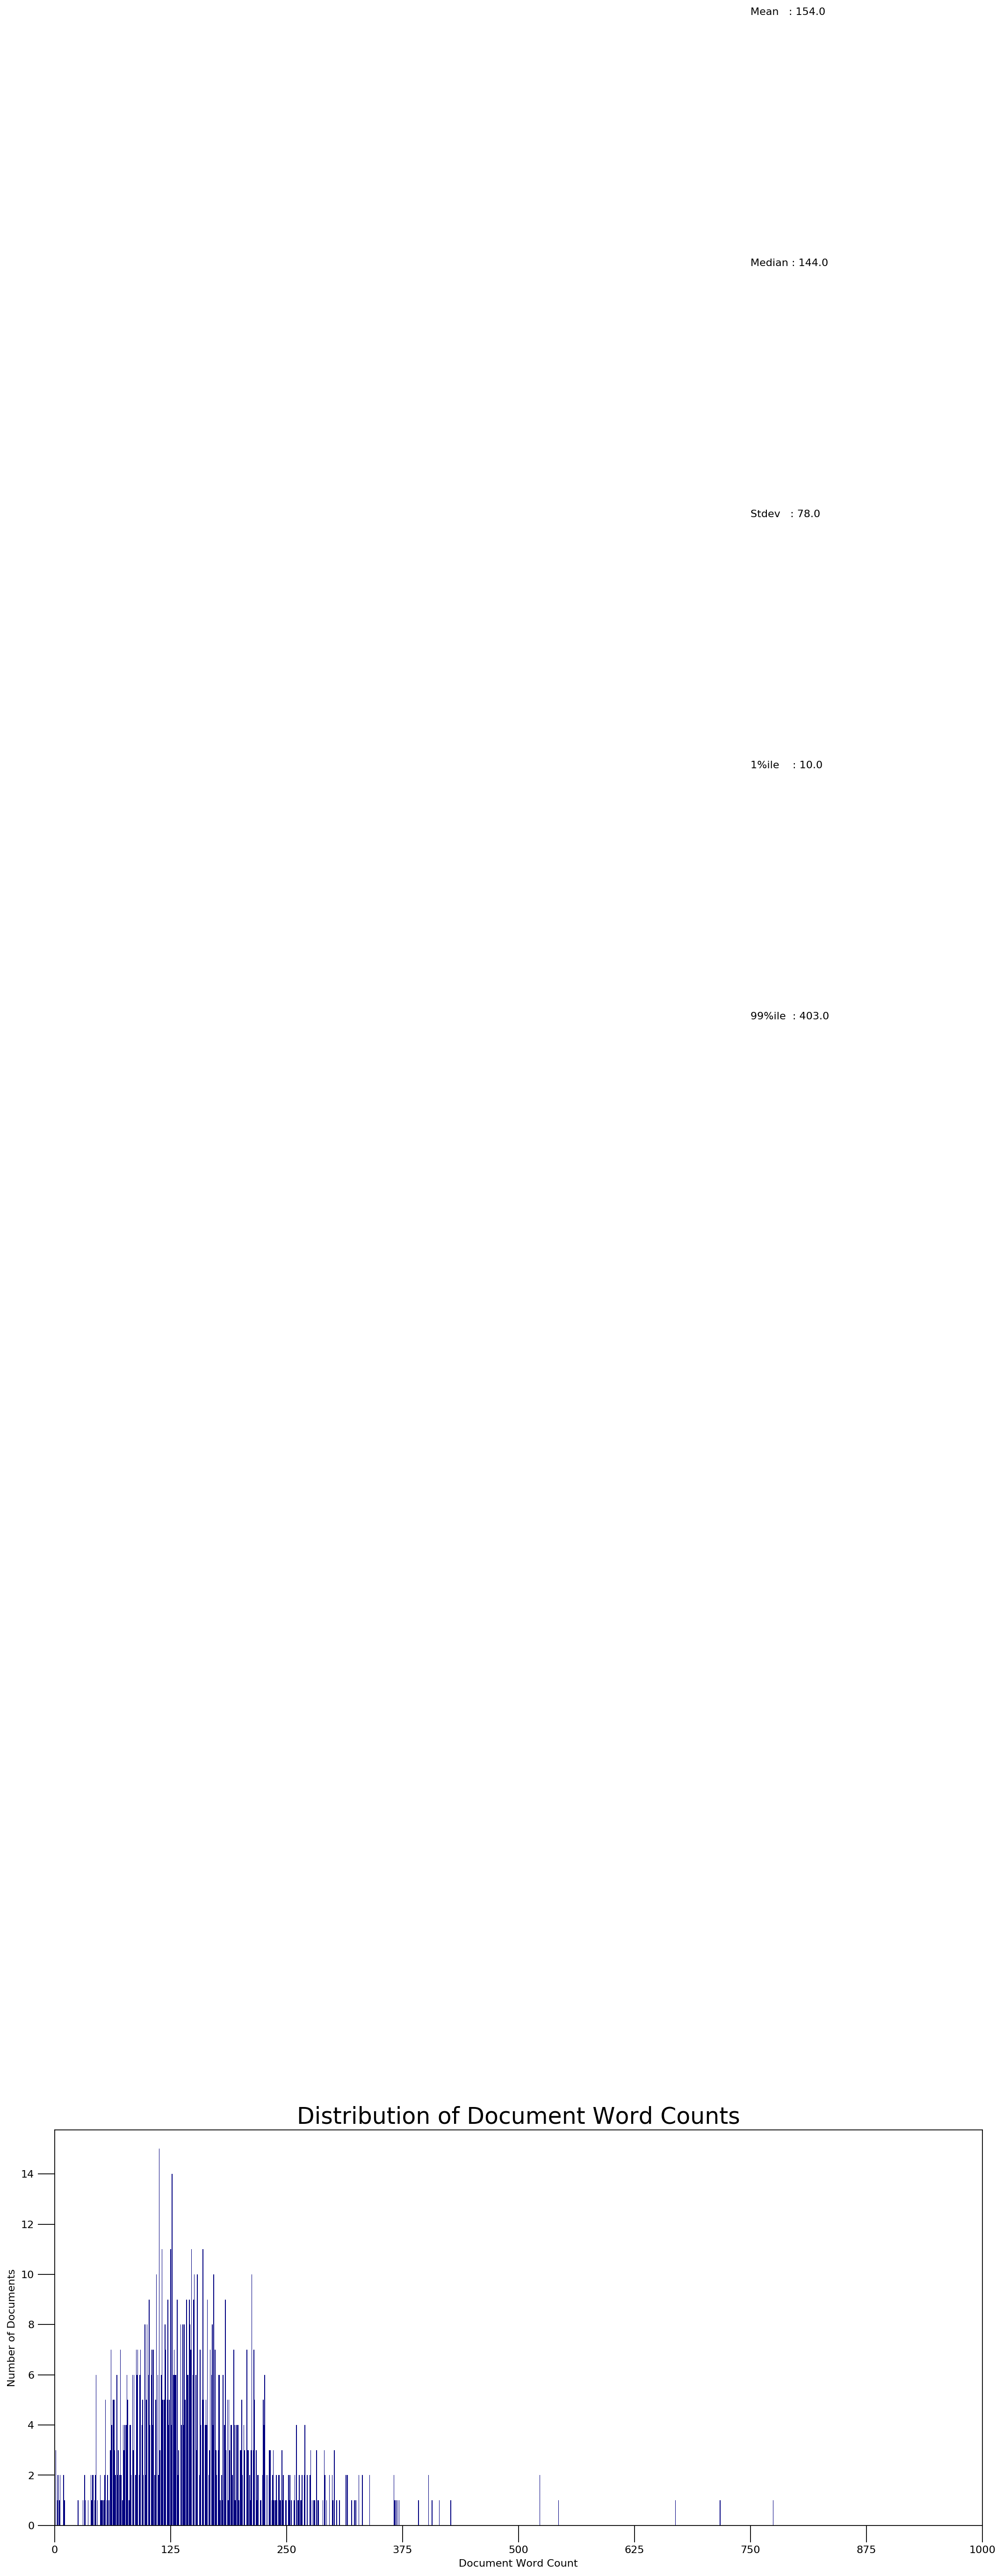

In [29]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

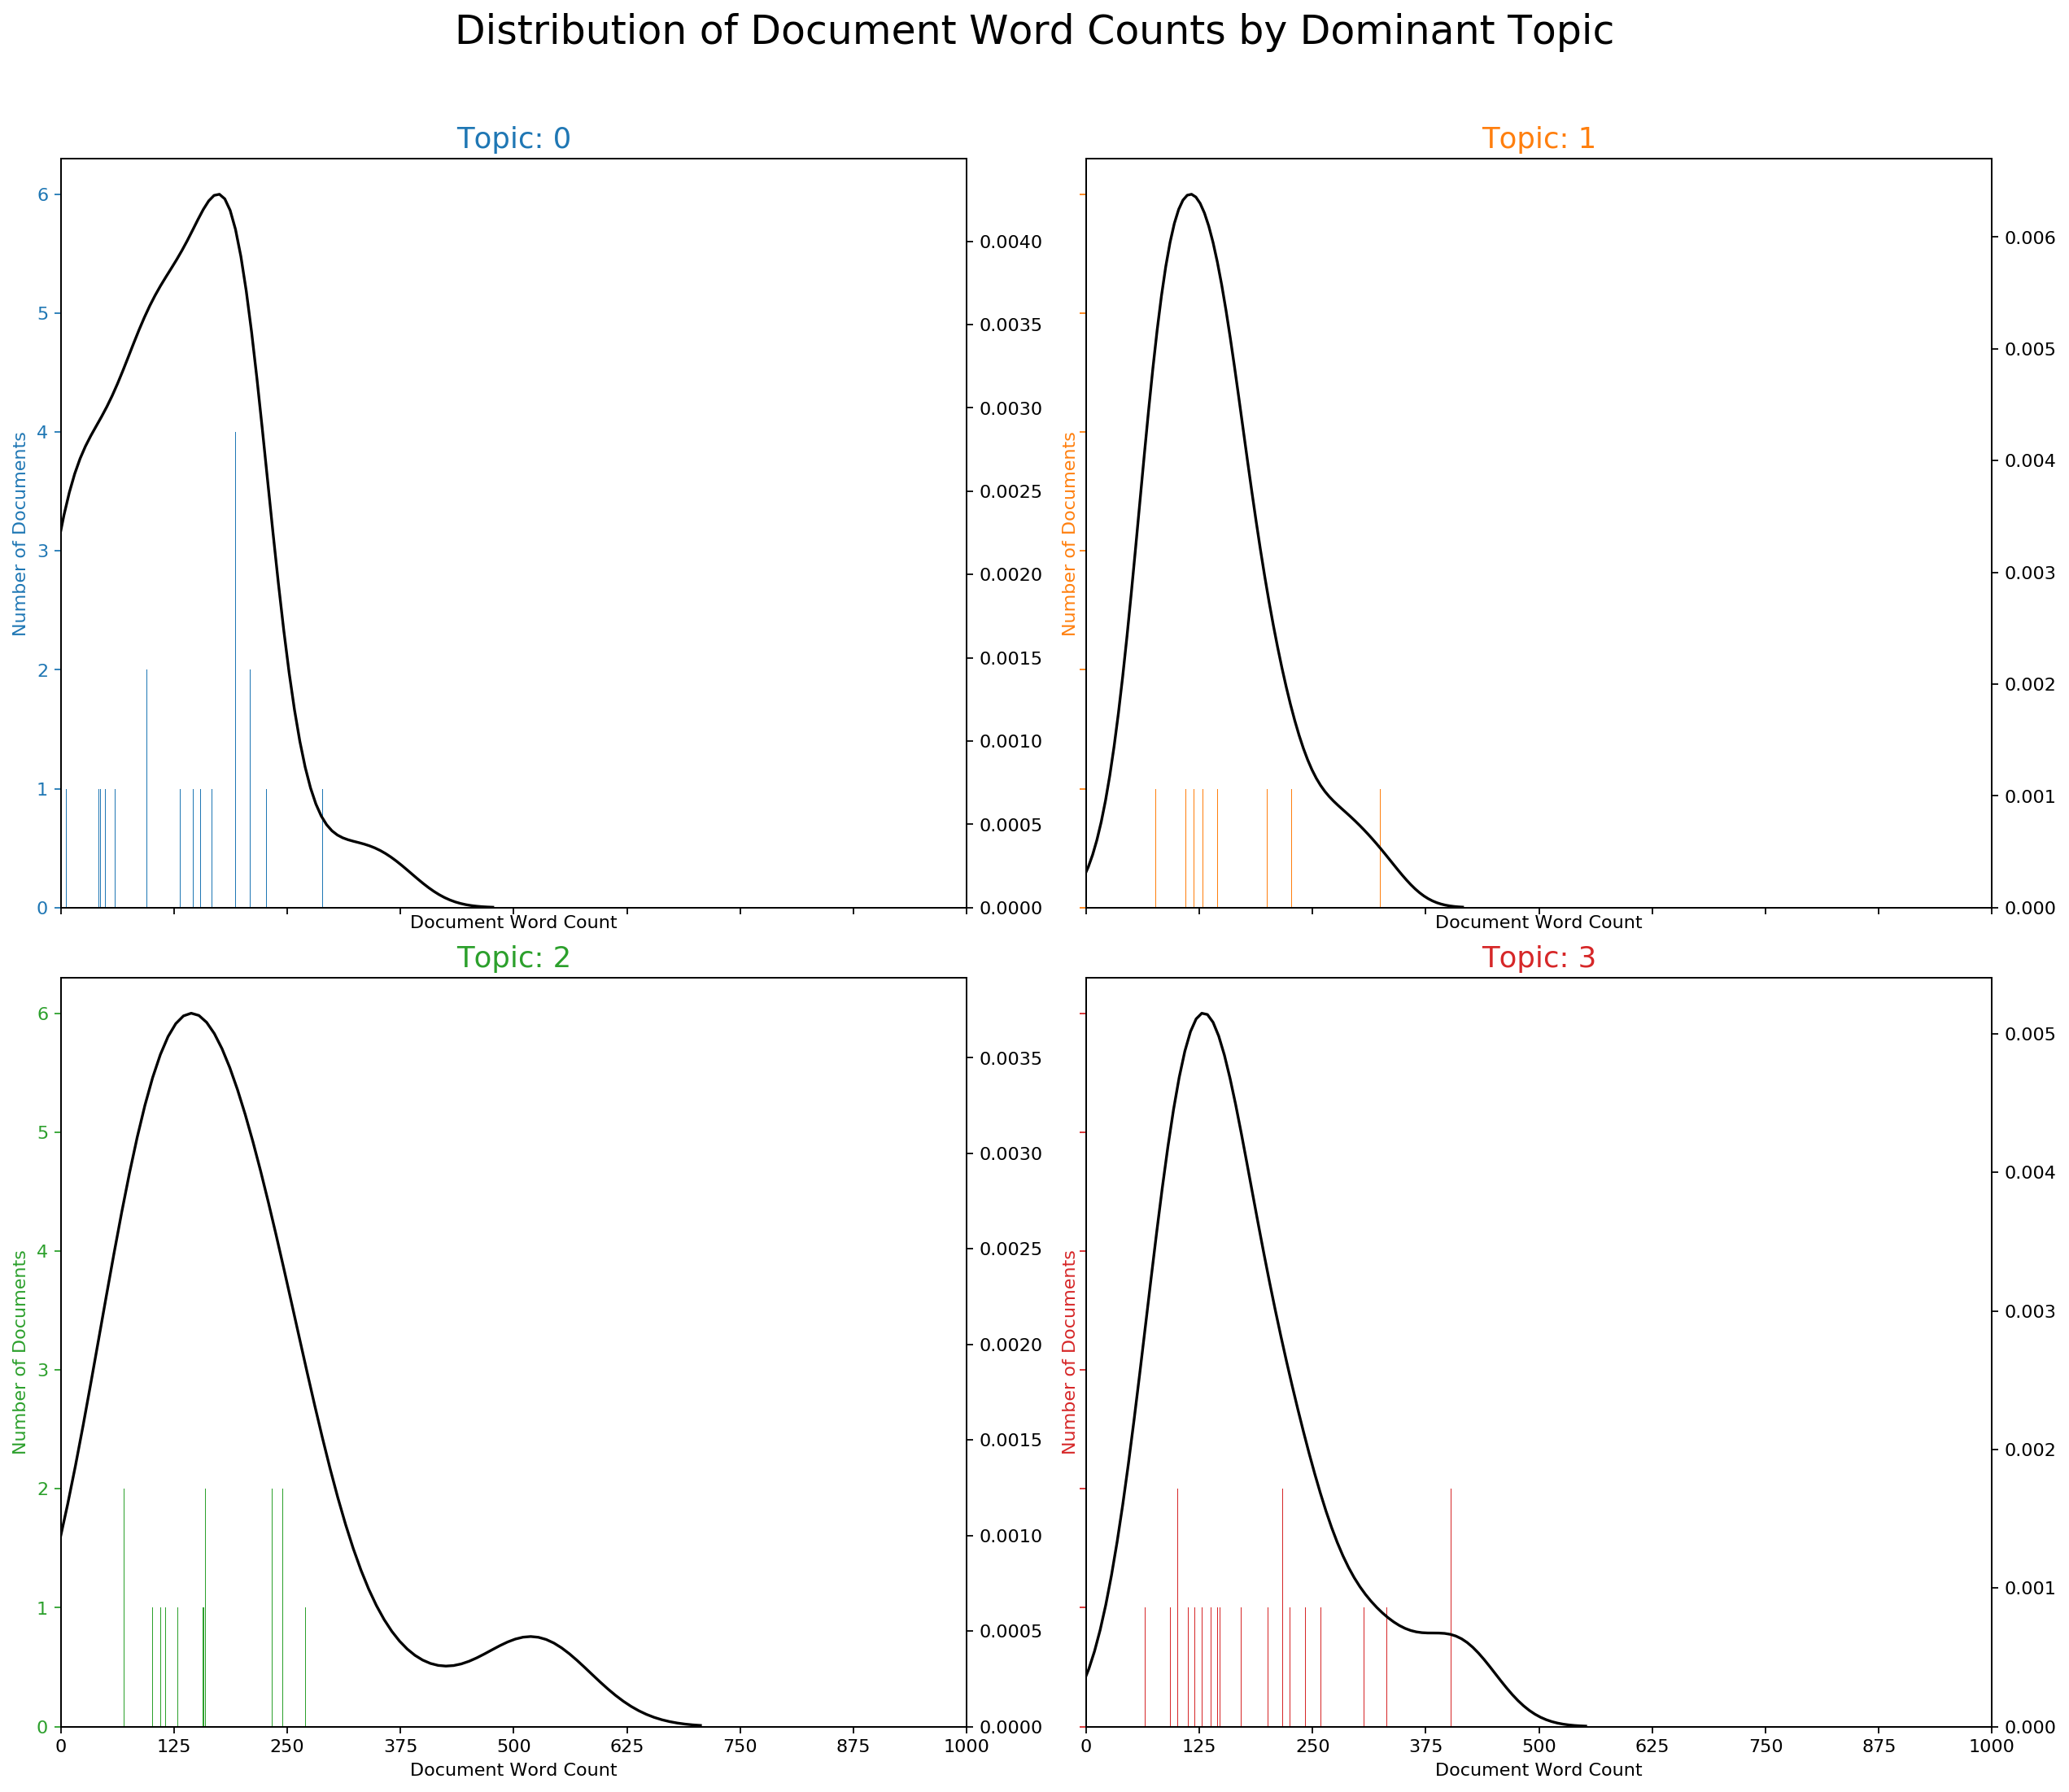

In [30]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

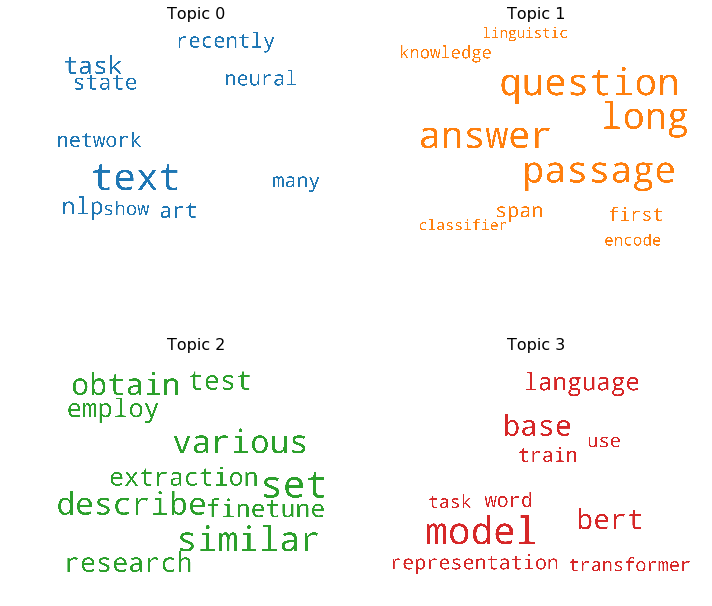

In [31]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.

In [32]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

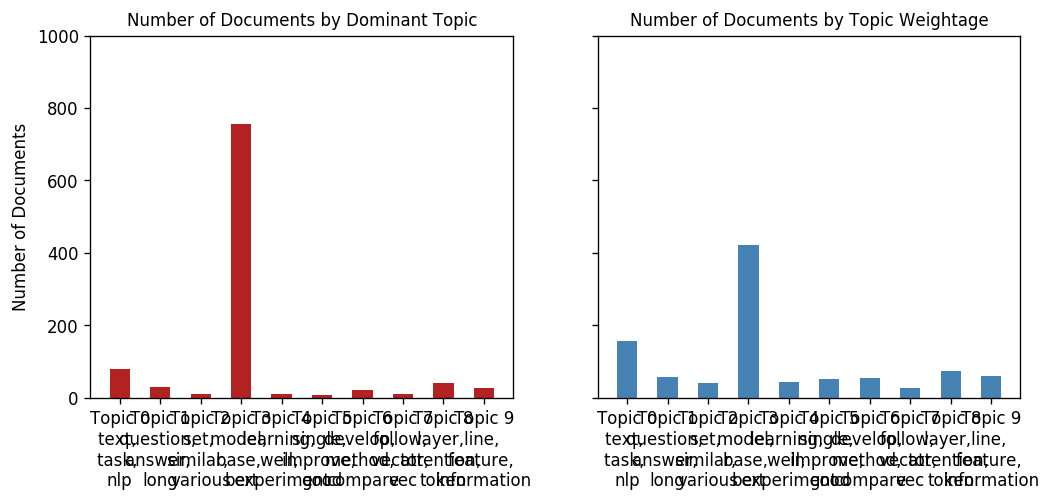

In [33]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [34]:
!pip3 install bokeh

You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 812 samples in 0.001s...
[t-SNE] Computed neighbors for 812 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 812 / 812
[t-SNE] Mean sigma: 0.074033
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.854496
[t-SNE] KL divergence after 1000 iterations: 0.704593


Loading BokehJS ...

Sentiment analysis:
we need to import tools for the NLTK: the VADER lexicon, which calculates negative, positive, and neutral values for our text, and a word tokenizer, which splits our large text file into sentences or words

In [36]:
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/virajaketkar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/virajaketkar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

#initialize VADER so we can use it within our Python script.

sid = SentimentIntensityAnalyzer()

#We will also initialize our 'english.pickle' word tokenizer function and give it a short name, 'tokenizer.'
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

#At this point, we then open up our first text file, 

f = open('abc.fix.txt')
fm = f.read()

#We then tell our tokenizer to break up our text file into a list of sentences.

sentences = tokenizer.tokenize(fm)

Our next step will find all sentences in our text file that include a specific keyword and designate these sentences as a list. In our example, I am choosing "model" as my keyword and I have designated our list of all sentences that include this word "modellist". The "*"s are wildcards which match everything before and after the word "model" itself. The last part of the code prints the first ten sentences in the list, so we can see that it worked.

In [38]:
import re

r = re.compile(".*model .*")
modellist = list(filter(r.match, sentences))
#print(modellist[:10]

we will run the sentiment analysis on those sentences that include the word "model."

In [39]:
for sentence in modellist:
    print(sentence)
    scores = sid.polarity_scores(sentence)
    for key in sorted(scores):
          print('{0}: {1}, '.format(key, scores[key]), end='')
    print()

', 'The model is then trained with the objective that the outside representations of the leaf cells should reconstruct the corresponding leaf input word, analogous to masked language model <REF> pretraining, except by using dynamic programming we predict every word from a completely unmasked context.
compound: 0.3818, neg: 0.0, neu: 0.943, pos: 0.057, 
', 'We build on this latter line of work, focusing on the BERT model <REF>, and use a suite of probing tasks  derived from the traditional NLP pipeline to quantify where specific types of linguistic information are encoded.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
', 'The BERT model <REF> has shown state-of-the-art performance on many tasks, and its deep Transformer architecture  is typical of many recent models (e.g.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
', 'This approach can also be applied in order to train a model dedicated to a new slot filling task from an already pre-trained model (here ASR • N ER), in the same spirit

compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
', 'Kim purposed the attention-based classifier that can achieve multi-label emotion classification <REF>; Yang applied a sequence generation model with a novel decoder structure to solve it with correlations between labels ;  created various attention mechanisms for NLP that applied into text classification by others; There was a new module that can sheep up training ; Zhang achieved text classification with the correlation between different task data ; And  explored the influence of different semantic embedding to multi-label text classification.
compound: 0.6249, neg: 0.0, neu: 0.921, pos: 0.079, 
', 'For the classification module of our proposed approach, we adopt the widely popular BERT model <REF> which we refer to as just BERT.
compound: 0.5423, neg: 0.0, neu: 0.83, pos: 0.17, 
', 'For the classification module of our proposed approach, we adopt the widely popular BERT model <REF> which we refer to as just BERT.
compound: 0.5423, neg